In [9]:
# All imports go here
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import word2vec
import scispacy
import en_core_sci_md
import warnings
from sklearn.manifold import TSNE
import gensim.downloader as api
warnings.filterwarnings("ignore")

In [10]:
# Load data into an organized dataframe
def create_adhd_df(notes_file):
    # Load the data
    df = pd.read_csv(notes_file, quotechar='"')

    # Load into organized dataframe
    adhd_df = pd.DataFrame(columns=['row_id', 'subject_id', 'personnel', 'category', 'text'])
    adhd_dict = {"row_id":[],"subject_id":[], "personnel": [], "category":[], "text":[]};

    for i in range(0, len(df)):
        adhd_dict["row_id"].append(df.loc[i][0])
        adhd_dict["subject_id"].append(df.loc[i][1])
        adhd_dict["category"].append(df.loc[i][2])
        adhd_dict["personnel"].append(df.loc[i][3])
        adhd_dict["text"].append(df.loc[i][4])

    adhd_df = pd.DataFrame(adhd_dict)
    return adhd_df

# Extract entities using all methods (Functions only)

In [11]:
# Extract entities using Spacy
import re
def spacy_extract_entities(df, nlp, print_output=False):
    corpus = []
    for row in range(0, len(df)):
        str_tokens=[]
        tokens = nlp(df[row]).ents

        for token in tokens:
            clean_token = token.text.strip()
            clean_token = re.sub(r"^a-zA-Z0-9-]", "", clean_token)

            if clean_token:
                str_tokens.append(clean_token)
        #
        # for i in range(0, len(tokens)):
        #     str_tokens.append(tokens[i].text)
        corpus.append(list(str_tokens))
    return corpus

In [12]:
# Plot the extracted entities
def plot_entities(model, words, title, use_wv=True, map_size=(16, 16)):
    labels = []
    tokens = []

    for word in words:
        if use_wv:
            if word in model.wv:
                tokens.append(model.wv[word])
                labels.append(word)
            else:
                print(f"skipping {word}")
        else:
            if word in model:
                tokens.append(model[word])
                labels.append(word)
            else:
                print(f"skipping {word}")

    tnse_model = TSNE(perplexity=11, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tnse_model.fit_transform(np.array(tokens))

    x = [value[0] for value in new_values]
    y = [value[1] for value in new_values]

    plt.figure(figsize=map_size)
    plt.title(title)
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i], xy=(x[i],y[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
    plt.grid(True)
    plt.show()

# Run the pipeline

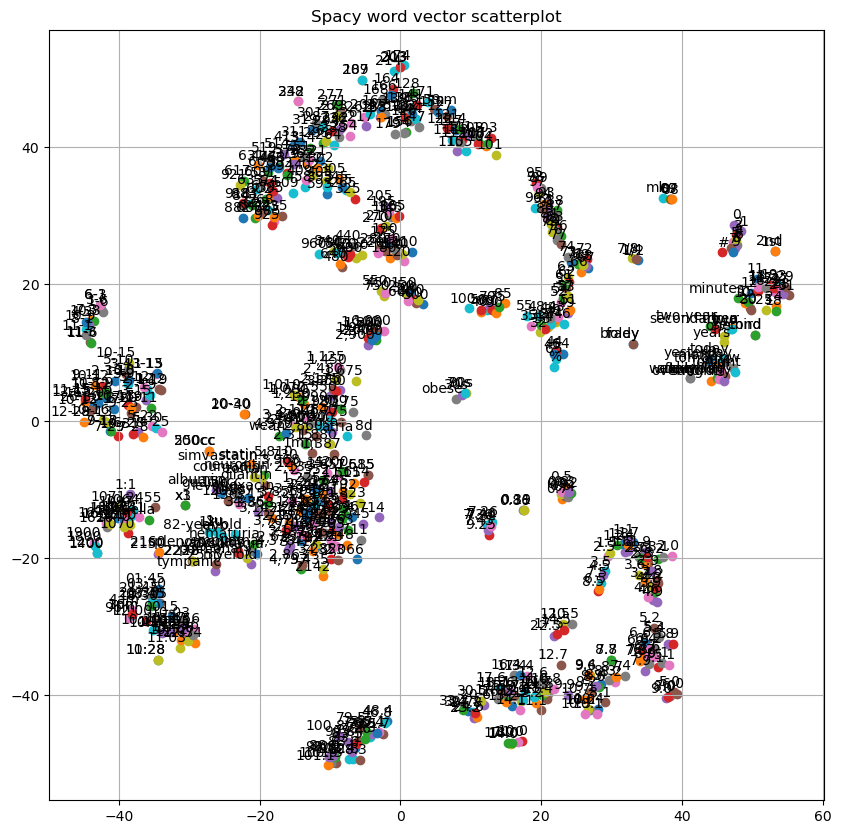

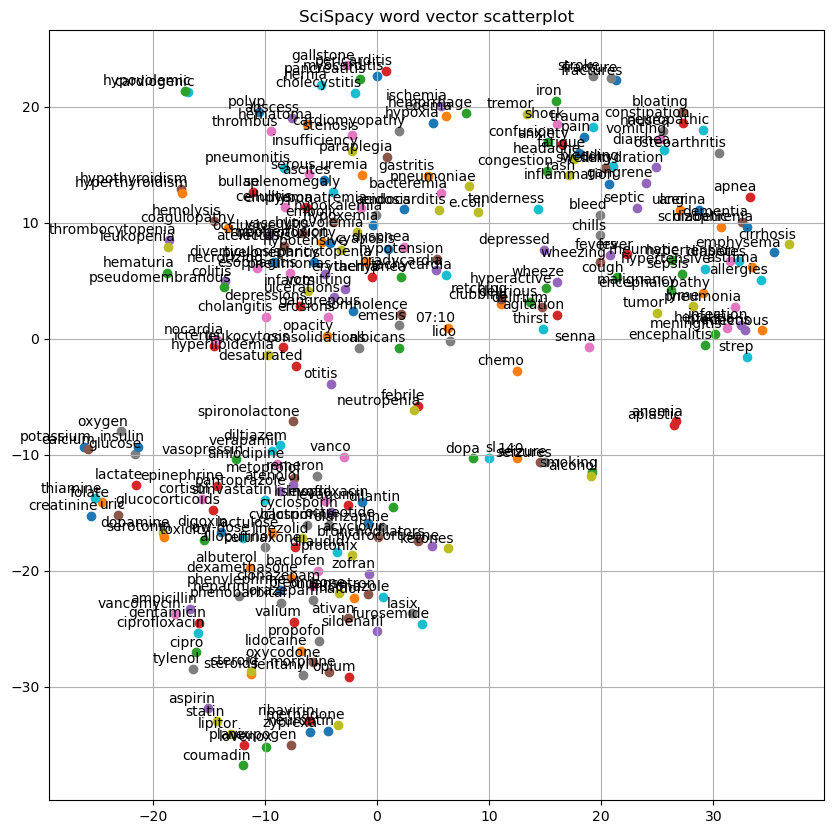

In [15]:
# Call above functions to run the pipeline
_adhd_notes_file = 'dataframe_output/adhd_md.csv' # Variants: 'adhd_sm.csv' (10 items), 'adhd_md.csv' (100 items), 'adhd_lg.csv' (all items)
_map_size = (10,10)

# NLPs
spacy_nlp = spacy.load('en_core_web_sm')
scispacy_nlp = en_core_sci_md.load()
ner_nlp = spacy.load("en_ner_bc5cdr_md") # en_ner_craft_md. en_ner_jnlpba_md  en_ner_bionlp13cg_md
p_model = api.load("glove-wiki-gigaword-50")

# Load the data

adhd_note_word_list = []
with open(_adhd_notes_file, 'r') as file:
    lines = file.readlines()
    for line in lines:
        adhd_note_word_list.append(line)

#df = pd.read_csv(_adhd_notes_file, quotechar='"')
#adhd_note_word_list = df['text'].astype(str).tolist()

# Spacy
spacy_corpus = spacy_extract_entities(adhd_note_word_list, spacy_nlp)
spacy_embeddings = word2vec.Word2Vec(spacy_corpus, min_count=1)
spacy_vocab = spacy_embeddings.wv.index_to_key
spacy_vector = np.array(list(spacy_vocab))
spacy_words = [word for word in spacy_vector if word in p_model.key_to_index]
plot_entities(p_model, spacy_words, "Spacy word vector scatterplot", use_wv=False, map_size=_map_size)

# Scispacy
sci_corpus = spacy_extract_entities(adhd_note_word_list, ner_nlp)
sci_embeddings = word2vec.Word2Vec(sci_corpus, min_count=1)
sci_vocab = sci_embeddings.wv.index_to_key
sci_vector = np.array(list(sci_vocab))
sci_words = [word for word in sci_vector if word in p_model.key_to_index]
plot_entities(p_model, sci_words, "SciSpacy word vector scatterplot",use_wv=False, map_size=_map_size)